In [1]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import lyricsgenius
from textblob import TextBlob
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
import csv
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
from dotenv import load_dotenv

In [2]:
# Load environment variables from .env
load_dotenv()

# Set up your Spotify API credentials
SPOTIPY_CLIENT_ID = os.getenv('SPOTIPY_CLIENT_ID')
SPOTIPY_CLIENT_SECRET = os.getenv('SPOTIPY_CLIENT_SECRET')

In [3]:
# Set up Spotify API authentication
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id=SPOTIPY_CLIENT_ID, client_secret=SPOTIPY_CLIENT_SECRET))

In [4]:
# Load Excel file
df = pd.read_excel('SMT_nummers.xlsx')
df['track'] = [f"{track['track_name']} - {track['artist_name']}" for _,track in df.iterrows()]
df

,track_name,artist_name,label,track
0,Walking On Sunshine,Katrina & The Waves,H,Walking On Sunshine - Katrina & The Waves
1,Perfect,Ed Sheeran,S,Perfect - Ed Sheeran
2,Beautiful Day,U2,H,Beautiful Day - U2
3,Easy On Me,Adele,S,Easy On Me - Adele
4,It's Gonna Be (Alright),Ween,S,It's Gonna Be (Alright) - Ween
5,The Scientist,Coldplay,S,The Scientist - Coldplay
6,Misery,Maroon 5,H,Misery - Maroon 5
7,Hard Times,Paramore,H,Hard Times - Paramore


In [5]:
def summarize_timbre(audio_analysis_data):
    # Extract timbre vectors for all segments
    timbre_vectors = [segment['timbre'] for segment in audio_analysis_data['segments']]

    # Transpose the timbre vectors to have each dimension as a separate list
    timbre_dimensions = np.array(timbre_vectors).T

    # Calculate mean for each dimension
    timbre_mean = [np.mean(dim) for dim in timbre_dimensions]

    return timbre_mean

In [6]:
def get_audio_features(playlist_uri):
    # Get playlist details from Spotify
    playlist = sp.playlist_tracks(playlist_uri)

    # List to store audio features
    audio_features_list = []
    
    for track in playlist['items']:
        track_id = track['track']['id']
        # Get audio features for the current track
        audio_features = sp.audio_features(track_id)[0]

        # Get low-level audio analysis for the current track
        audio_analysis_data = sp.audio_analysis(track_id)

        # Extract desired features
        tempo = audio_analysis_data['track']['tempo']
        time_signature = audio_analysis_data['track']['time_signature']
        key = audio_analysis_data['track']['key']
        timbre = summarize_timbre(audio_analysis_data)

        # Append features to the list
        audio_features.update({
            'name': track['track']['name'],
            'artist':track['track']['artists'][0]['name'],
            'timbre': timbre
        })

        # Append to the list
        audio_features_list.append(audio_features)

    return audio_features_list

def visualize_audio_features(audio_features_list):
    feature_names = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']

    for feature_name in feature_names:
        # Filter audio features and track names based on available labels in the dataframe
        filtered_audio_features = [track for track in audio_features_list if f"{track['name']} - {track['artist']}" in df['track'].values]
        feature_values = [track[feature_name] for track in filtered_audio_features]
        track_names = [f"{track['name']} - {track['artist']}" for track in filtered_audio_features]
        # Sort feature values and track names based on feature values
        sorted_indices = sorted(range(len(feature_values)), key=lambda k: feature_values[k])
        feature_values = [feature_values[i] for i in sorted_indices]
        track_names = [track_names[i] for i in sorted_indices]

        # Assign colors based on labels
        colors = np.where(np.array([track['label'] for track in filtered_audio_features])[sorted_indices] == 'S', 'blue', 'yellow')

        plt.figure(figsize=(15, 6))
        plt.bar(range(len(feature_values)), feature_values, color=colors)
        plt.title(f'{feature_name} for Each Song')
        plt.xlabel('Song Name')
        plt.ylabel(feature_name)

        # Rotate x-axis labels by 45 degrees
        plt.xticks(range(len(track_names)), track_names, rotation=45, ha='right', fontsize=8)

        plt.tight_layout()
        plt.show()


In [7]:
def classify_sad_happy(feature_values):
    # Classify songs based on the feature values
    threshold = int(len(feature_values) * 0.5)  # 70% threshold for Happy, 30% for Sad
    classified_labels = ['H' if i >= threshold else 'S' for i in range(len(feature_values))]
    return classified_labels

def compare_classification(feature_name, audio_features_list, df):
    # Extract feature values for the specified feature
    feature_values = [track[feature_name] for track in audio_features_list]
    track_names = [f"{track['name']} - {track['artist']}" for track in audio_features_list]
    # Sort feature values and track names based on feature values
    sorted_indices = sorted(range(len(feature_values)), key=lambda k: feature_values[k])
    feature_values = [feature_values[i] for i in sorted_indices]
    track_names = [track_names[i] for i in sorted_indices]

    # Classify songs based on the feature values
    classified_labels = classify_sad_happy(feature_values)
    classified_data = list(zip(track_names, classified_labels))

    # Check if classifications match
    golden_dict = df.set_index('track')['label'].to_dict()
    classifications = []
    for track, label in classified_data:
        if track in golden_dict:
            new_row = {
                "track": track,
                "classified_label": label,
                "correct_label": golden_dict[track]
            }
            if golden_dict[track] == label:
                new_row["correct"] = True
            else:
                new_row["correct"] = False
            classifications.append(new_row)
    
    # Separate tracks based on correctness
    correctly_classified_tracks = [item['track'] for item in classifications if item['correct']]
    incorrectly_classified_tracks = [item['track'] for item in classifications if not item['correct']]

    # Calculate accuracy score
    accuracy_score = sum(item['correct'] for item in classifications) / len(classifications)

    return accuracy_score


In [8]:
playlist_uri = 'https://open.spotify.com/playlist/6oWRp1nFvXT5ytvtAUwC7X?si=5972801d95ad4fbc'

audio_features_list = get_audio_features(playlist_uri)

In [9]:
def get_scores():
    feature_names = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']
    scores = {}
    for feature in feature_names:
        acc = compare_classification(feature, audio_features_list, df)
        scores[feature] = acc
    return scores

In [10]:
# Get the scores on how good it differentiates between sad/happy
scores = get_scores()
scores

{'danceability': 0.625,
 'energy': 1.0,
 'key': 0.5,
 'loudness': 0.75,
 'mode': 0.125,
 'speechiness': 0.875,
 'acousticness': 0.0,
 'instrumentalness': 0.5,
 'liveness': 0.5,
 'valence': 0.875,
 'tempo': 0.25,
 'duration_ms': 0.5}

In [11]:
updated_audio_features_list = []

for song_data in audio_features_list:
    track_name = f"{song_data['name']} - {song_data['artist']}"
    matching_row = df[df['track'] == track_name]
    
    if not matching_row.empty:
        song_data['label'] = matching_row['label'].values[0]
        updated_audio_features_list.append(song_data)
        
audio_features_list = updated_audio_features_list

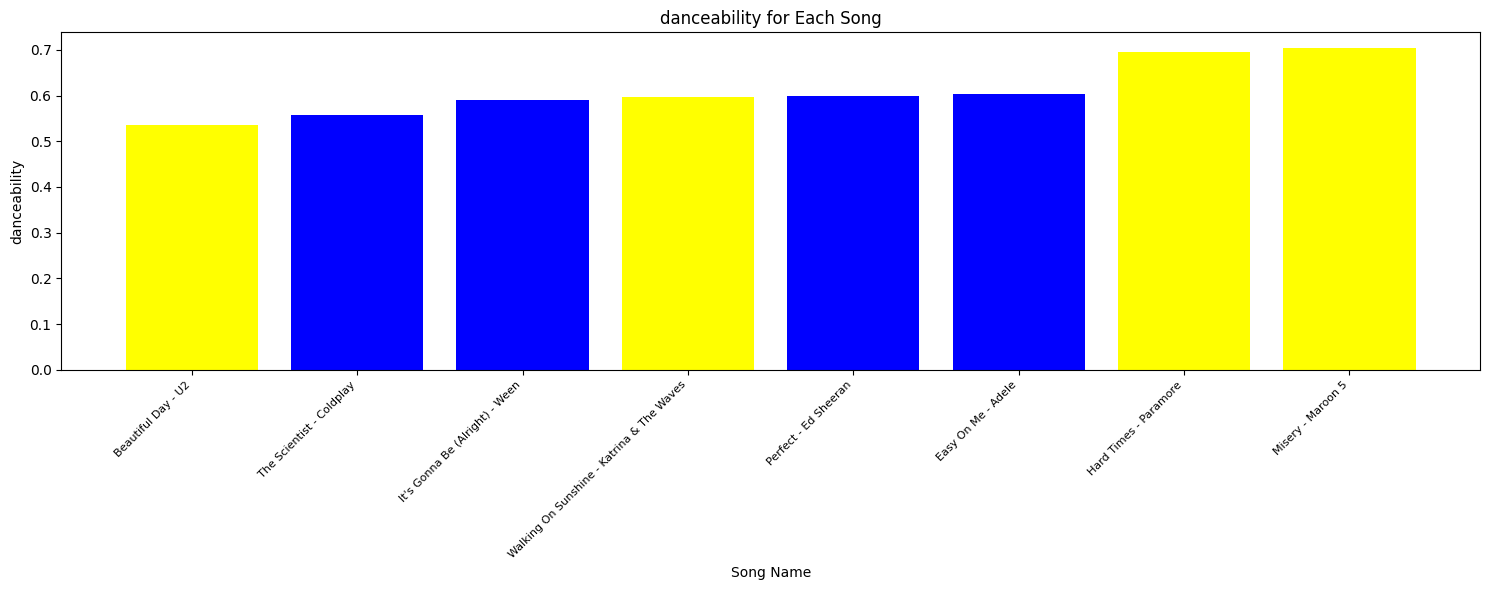

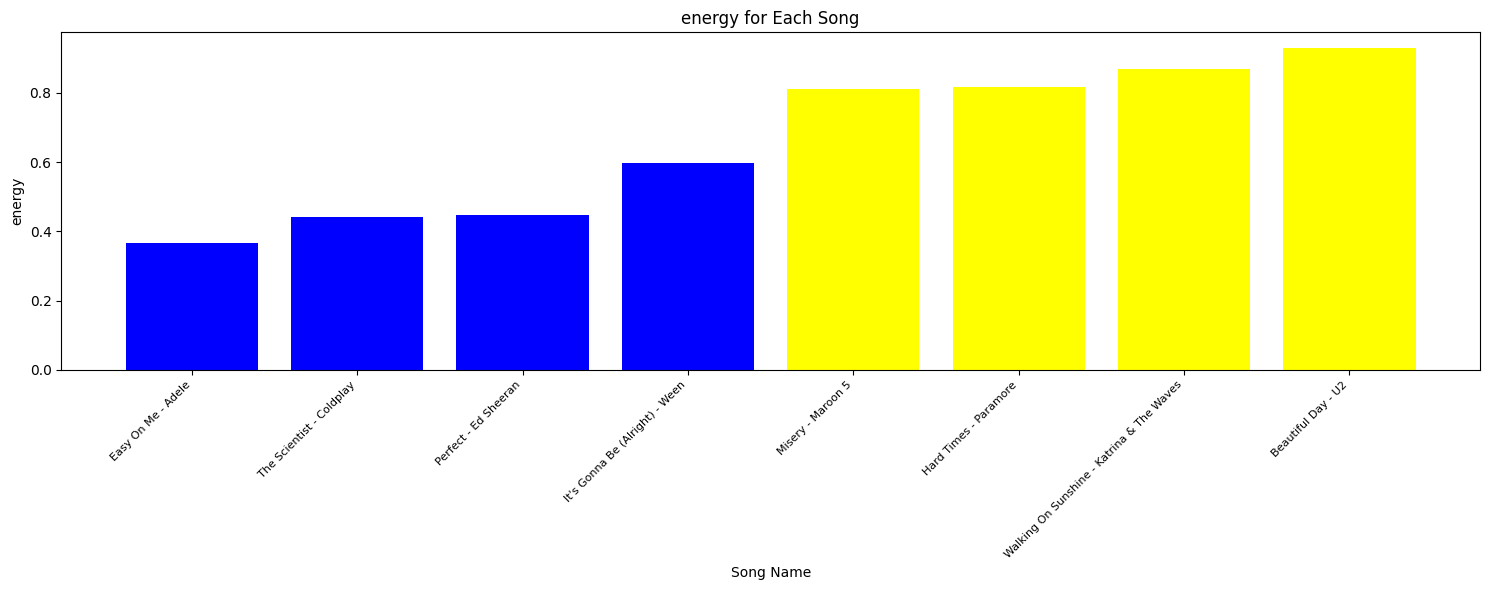

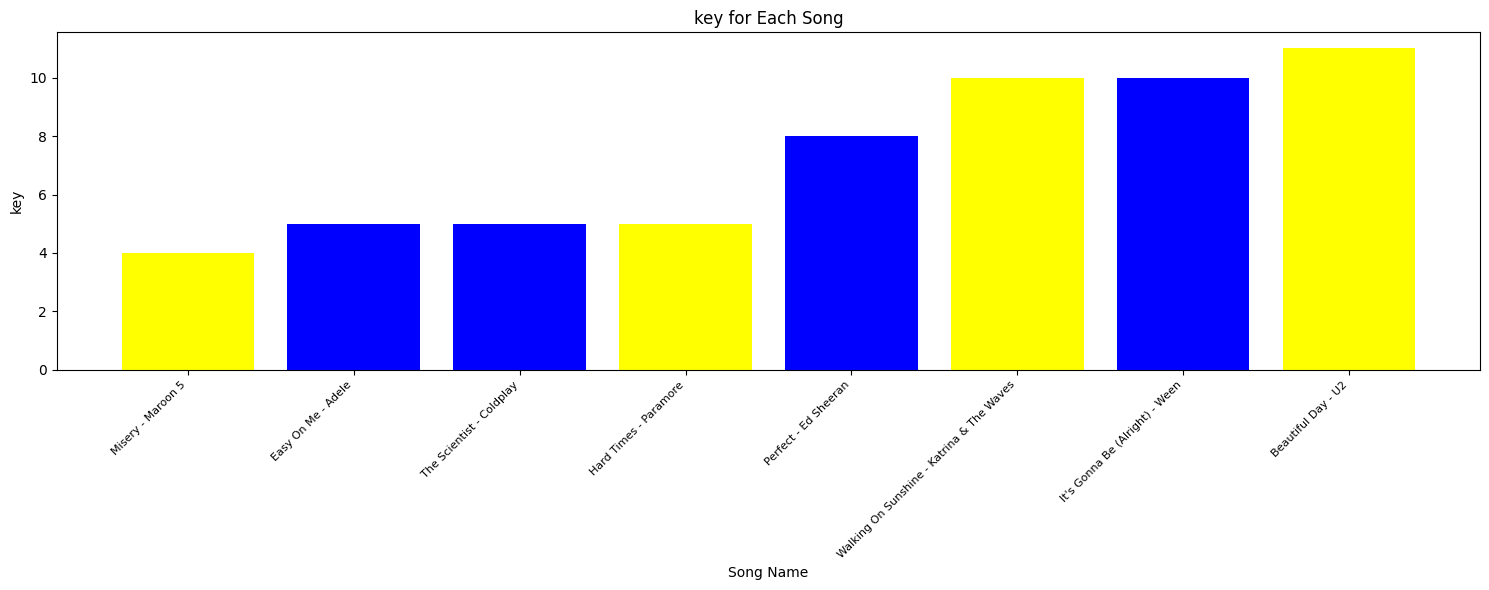

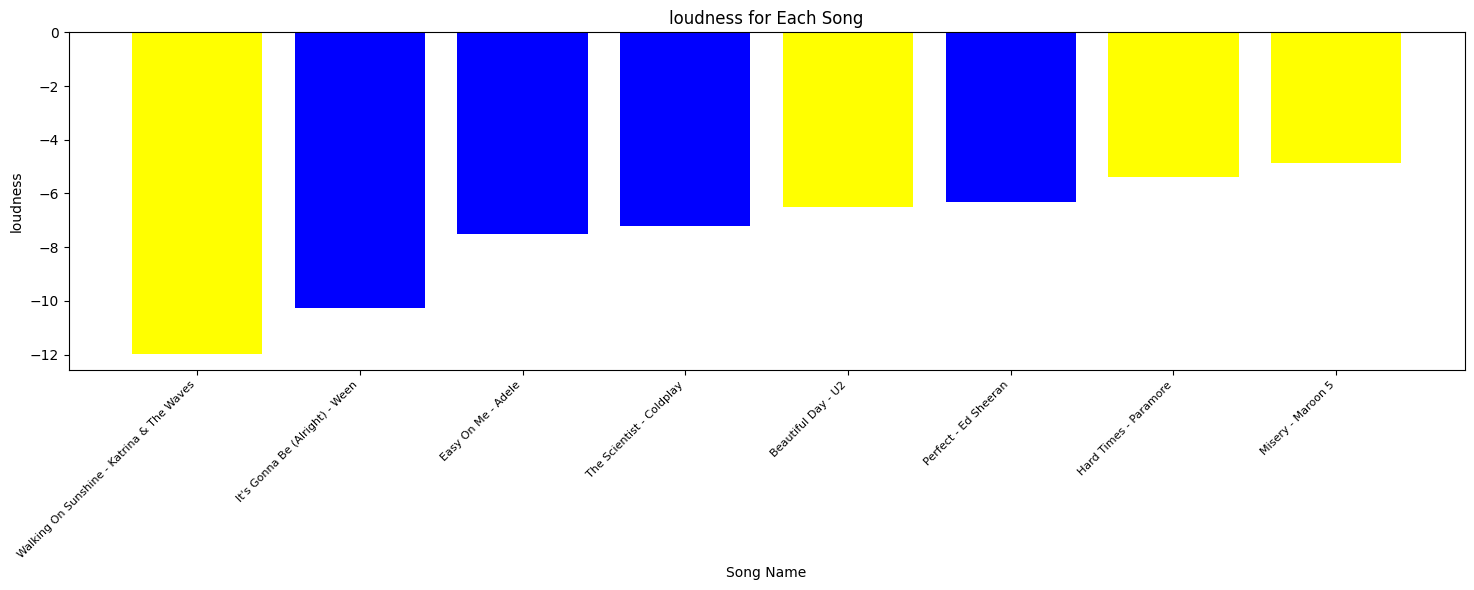

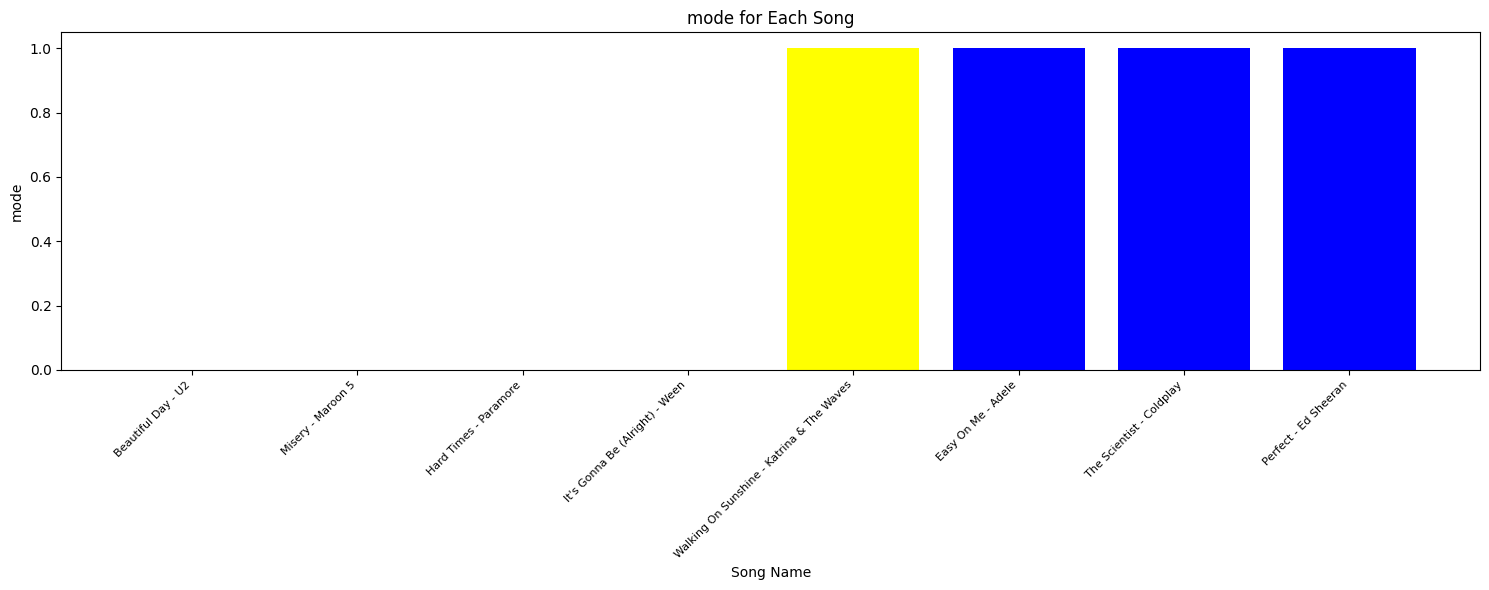

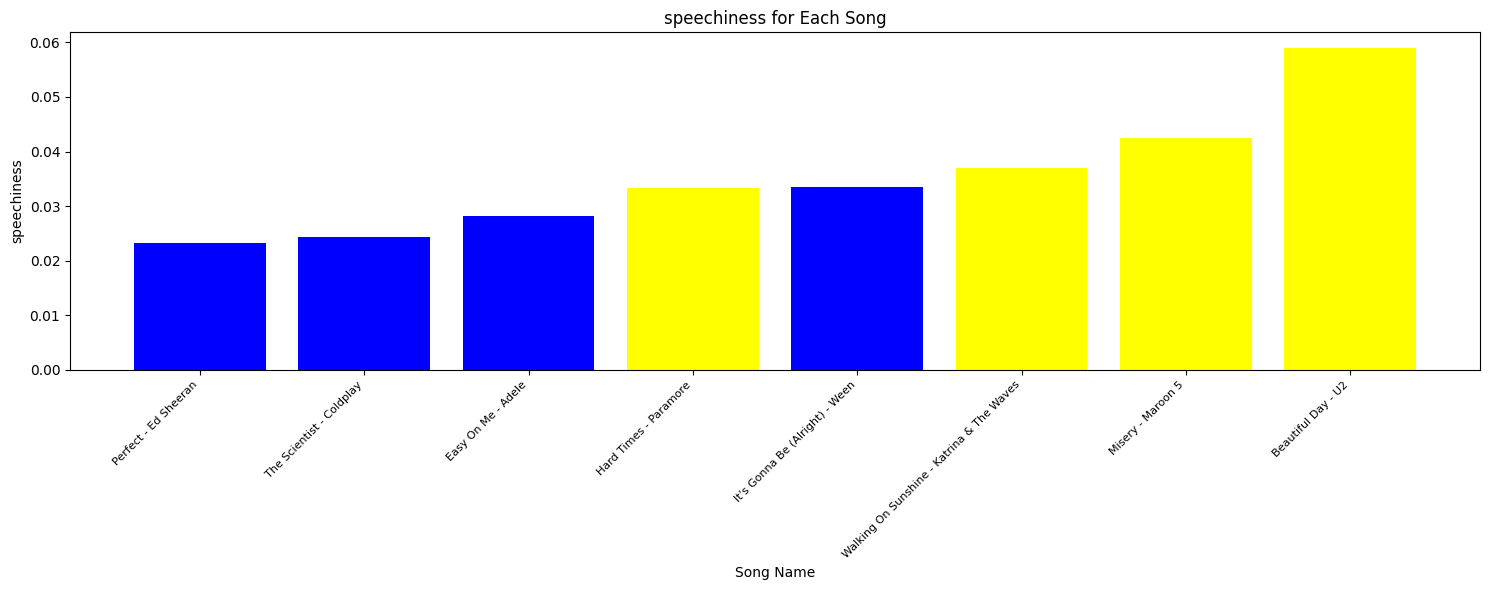

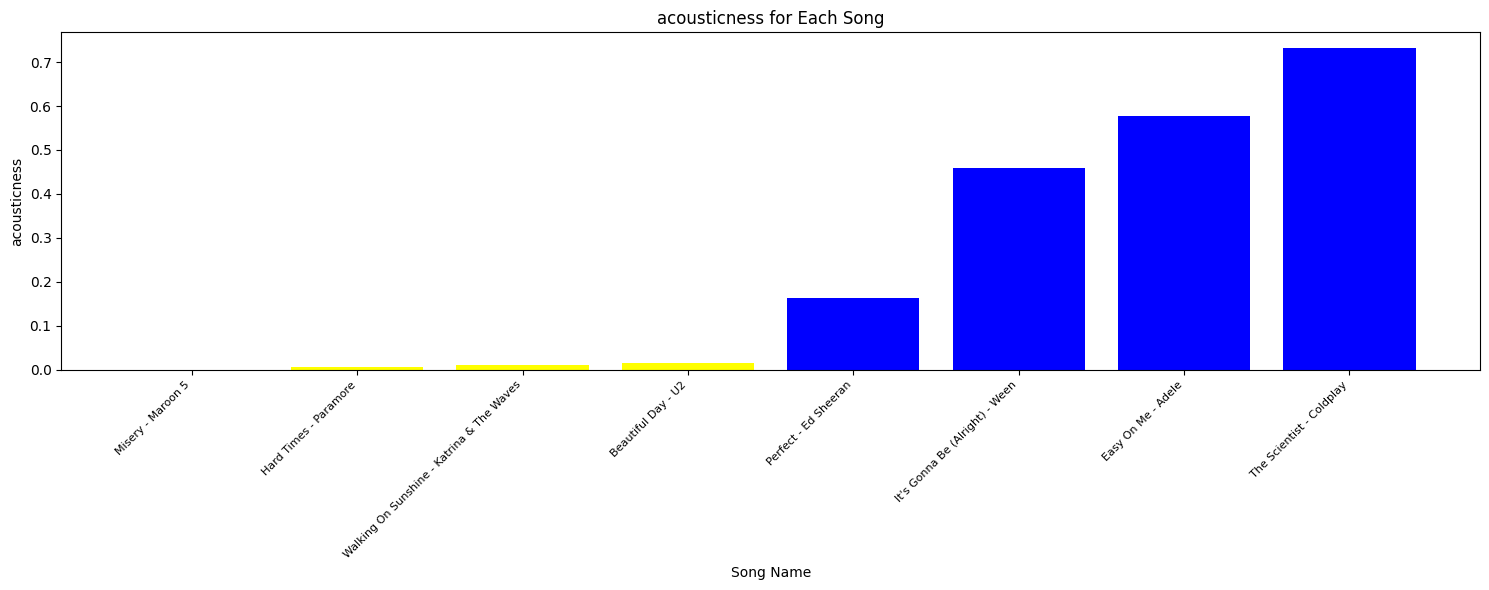

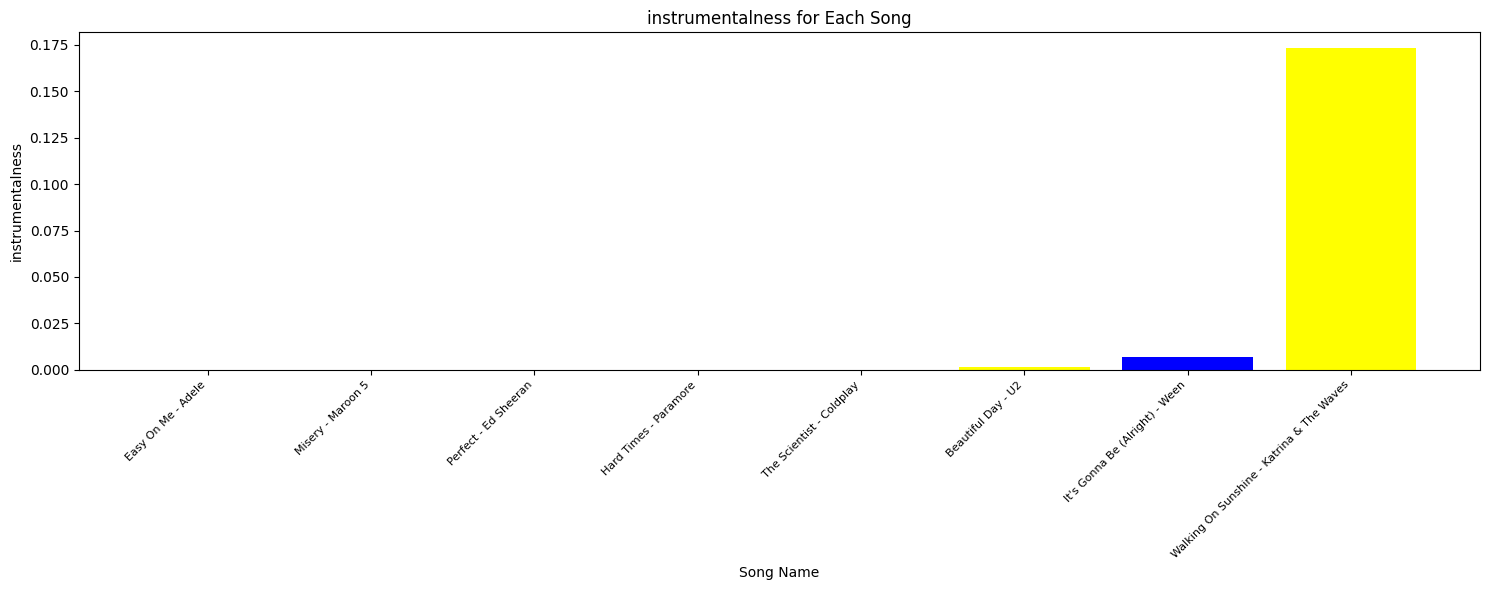

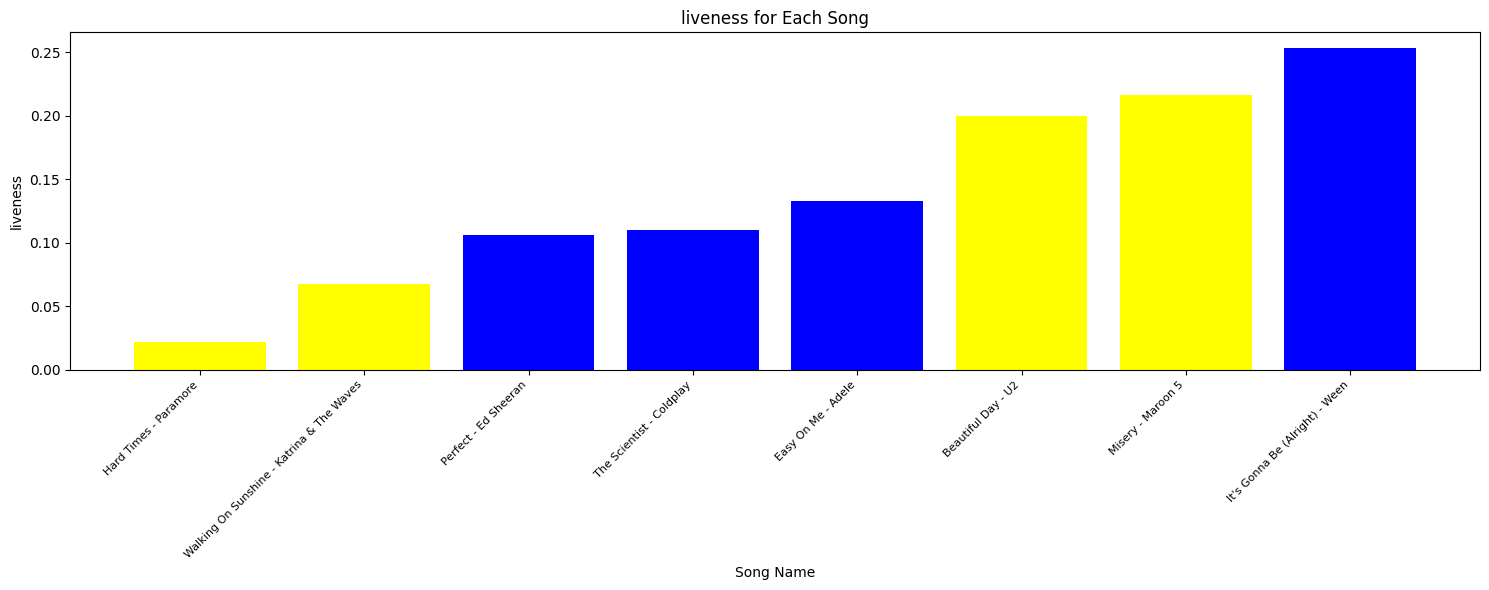

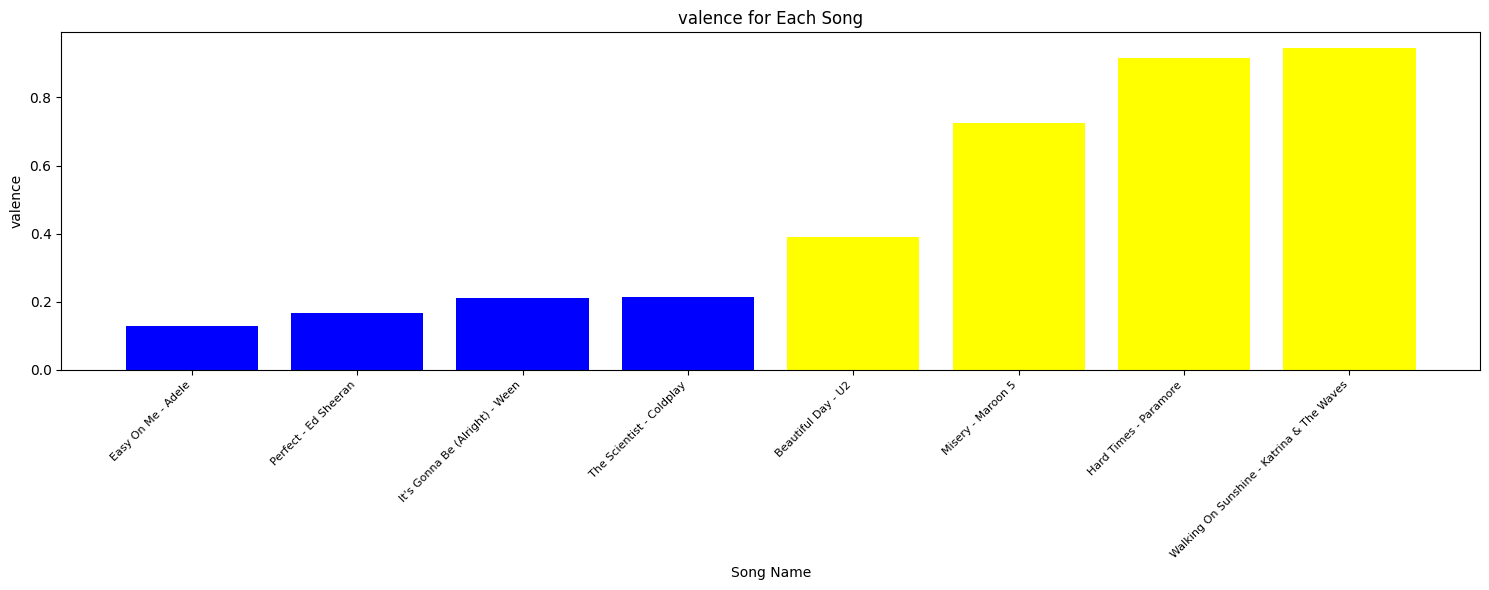

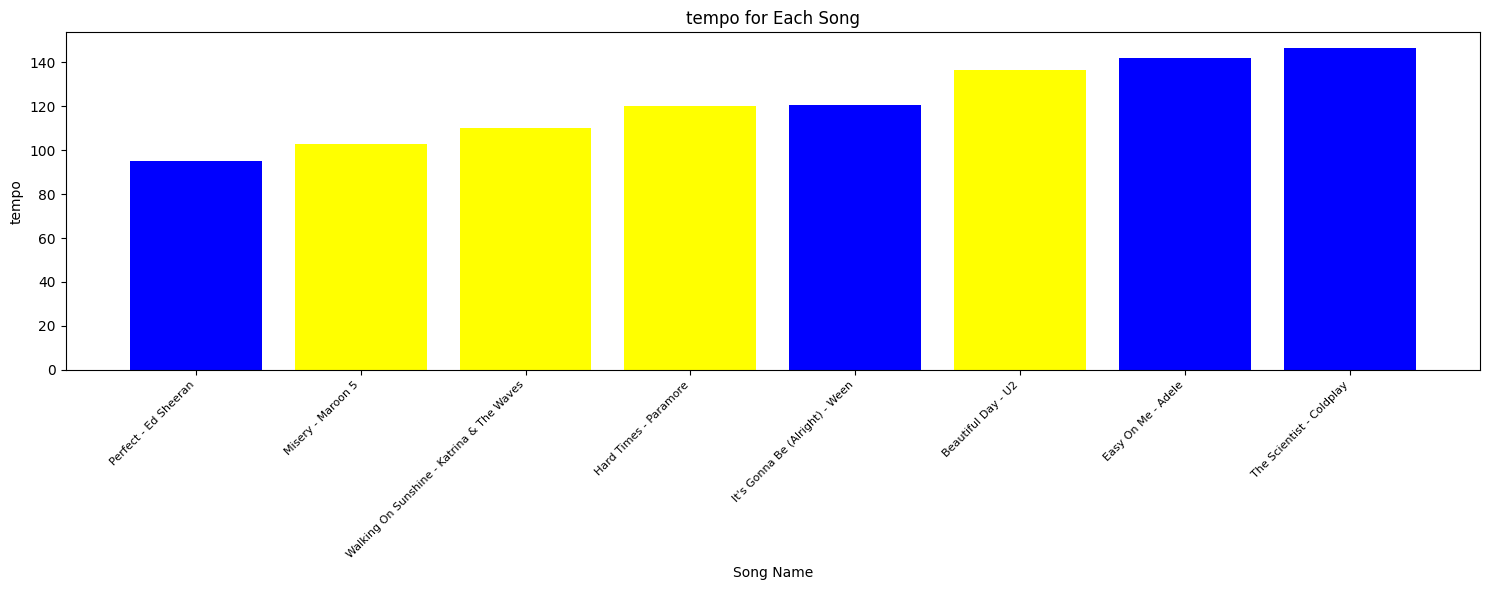

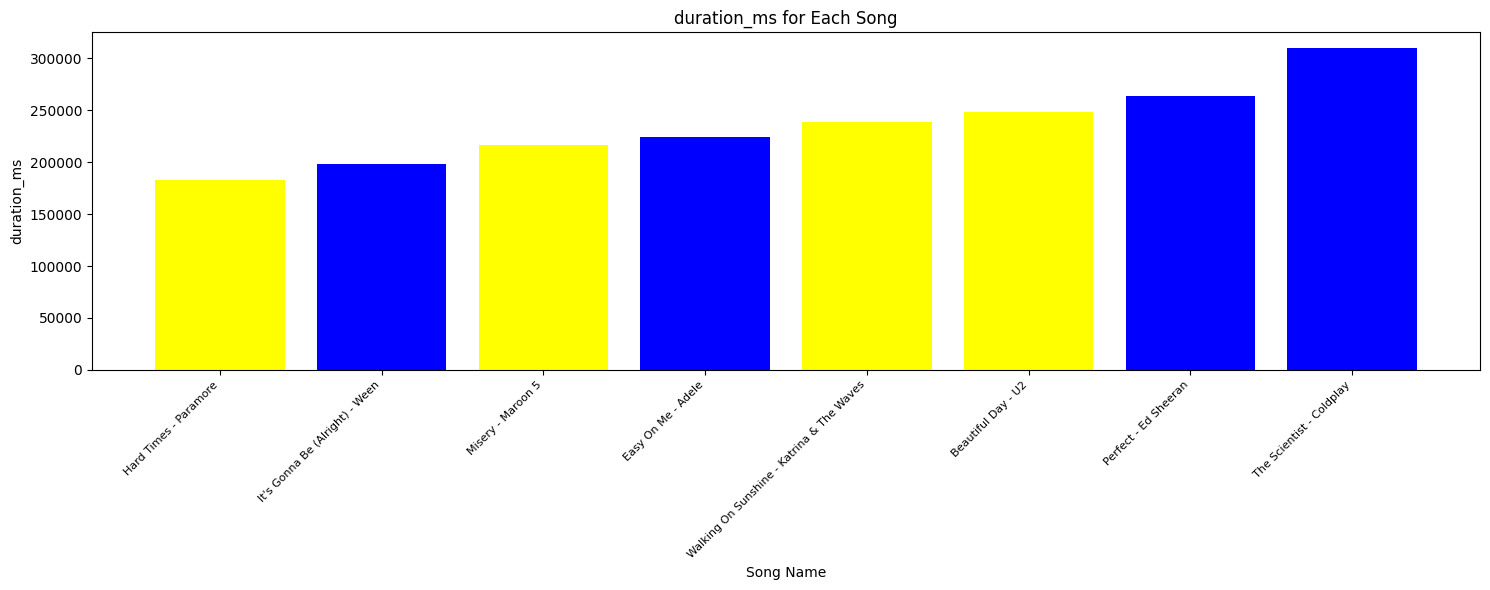

In [12]:
# Visualize audio features
visualize_audio_features(audio_features_list)

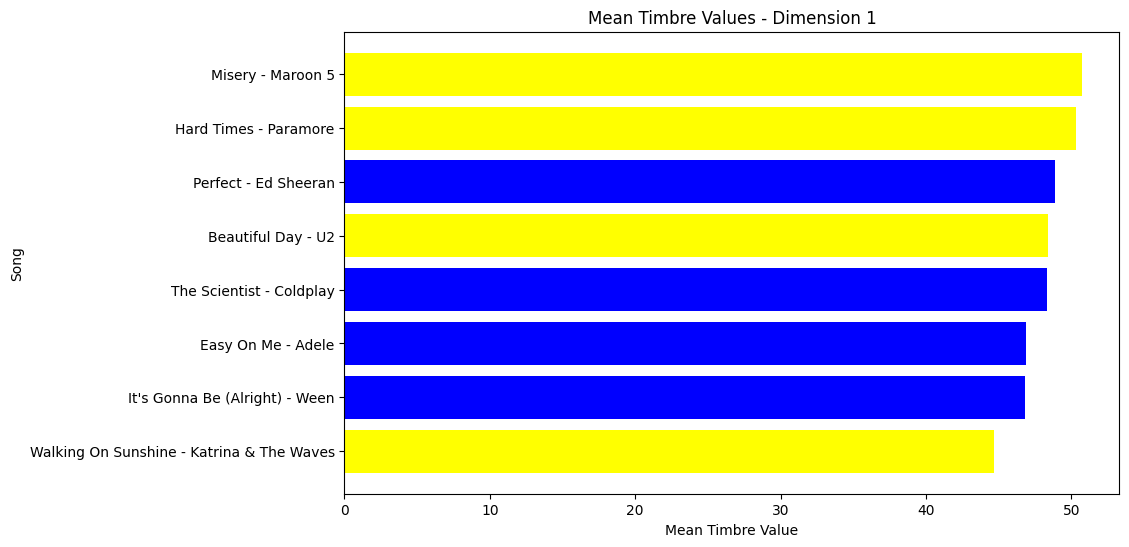

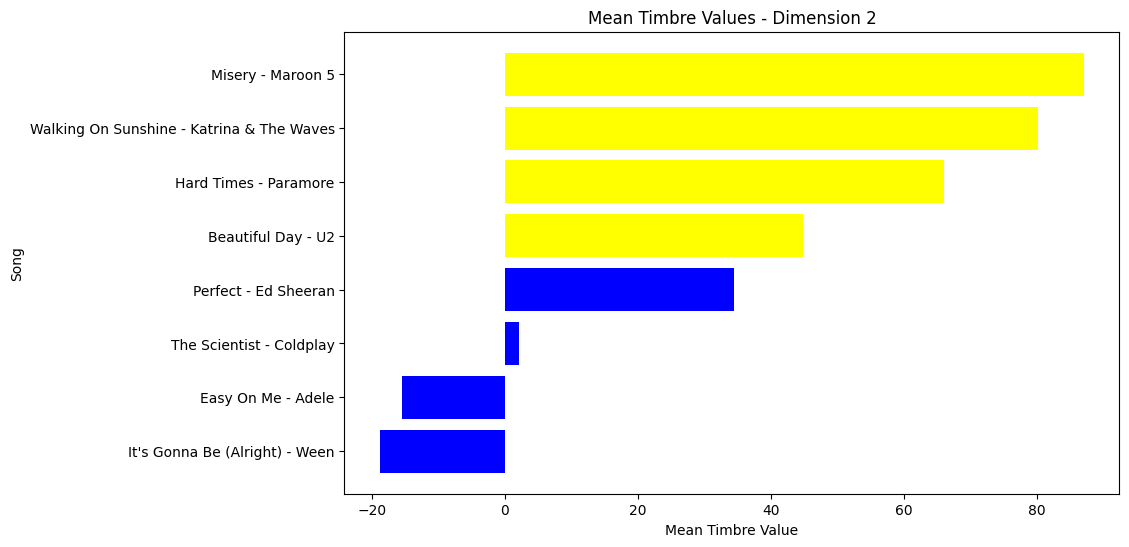

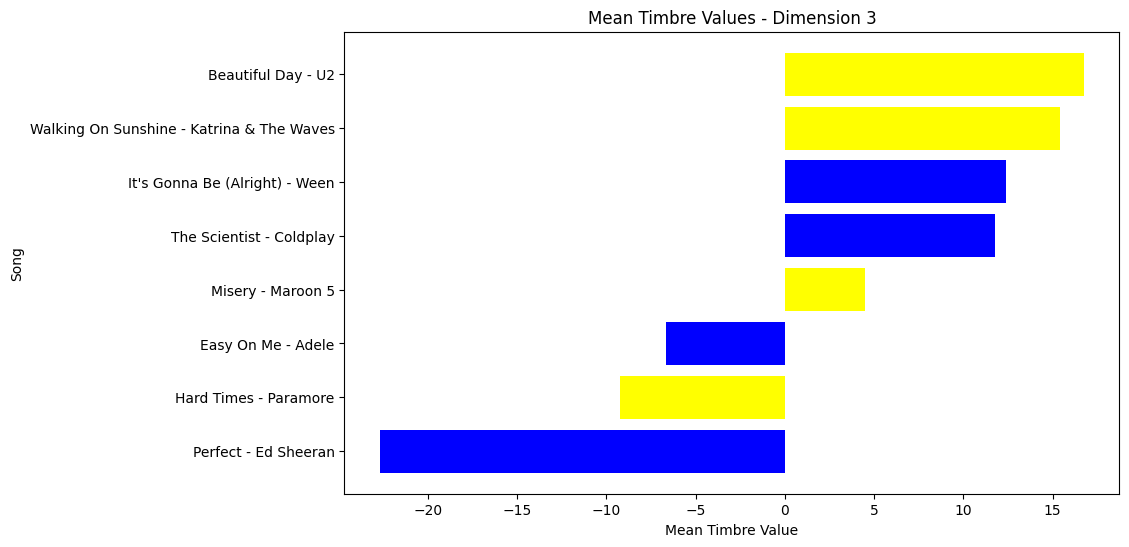

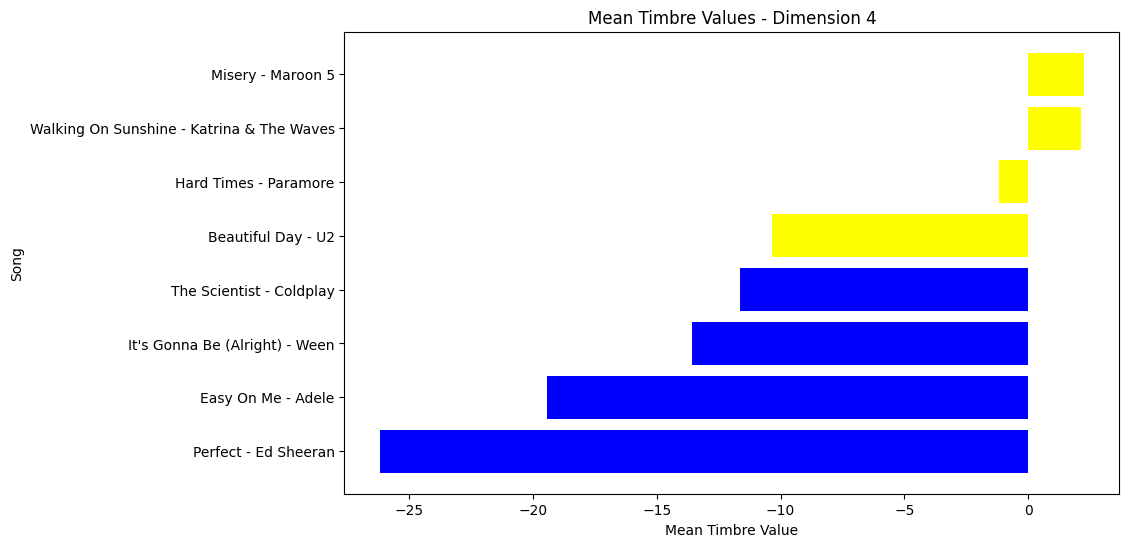

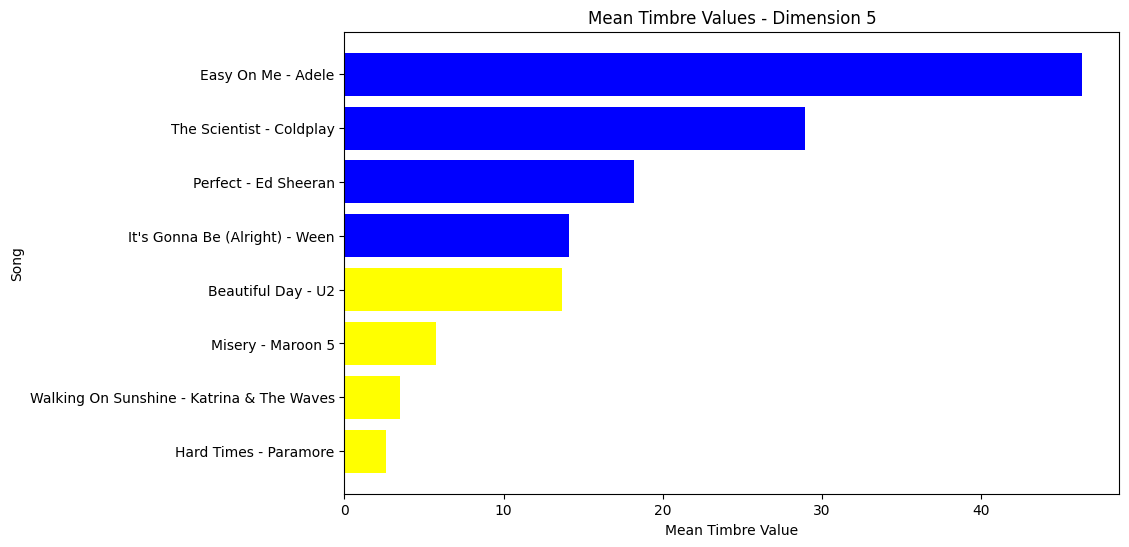

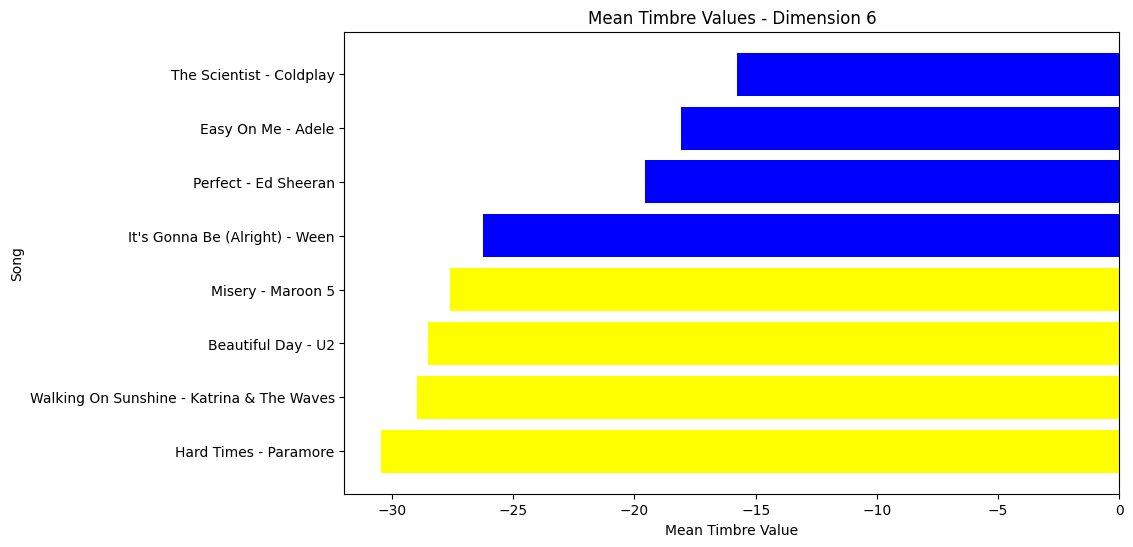

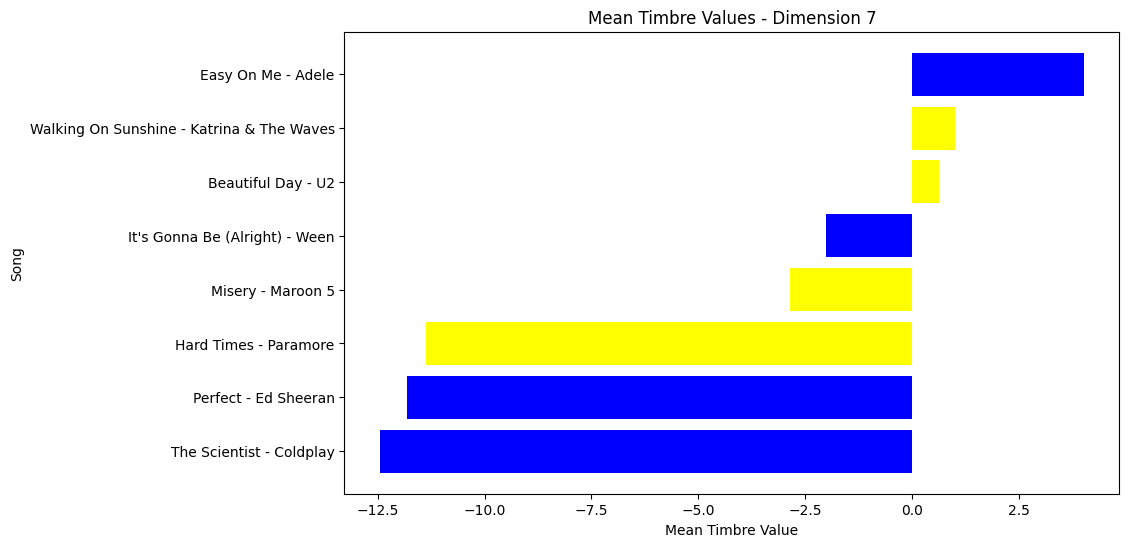

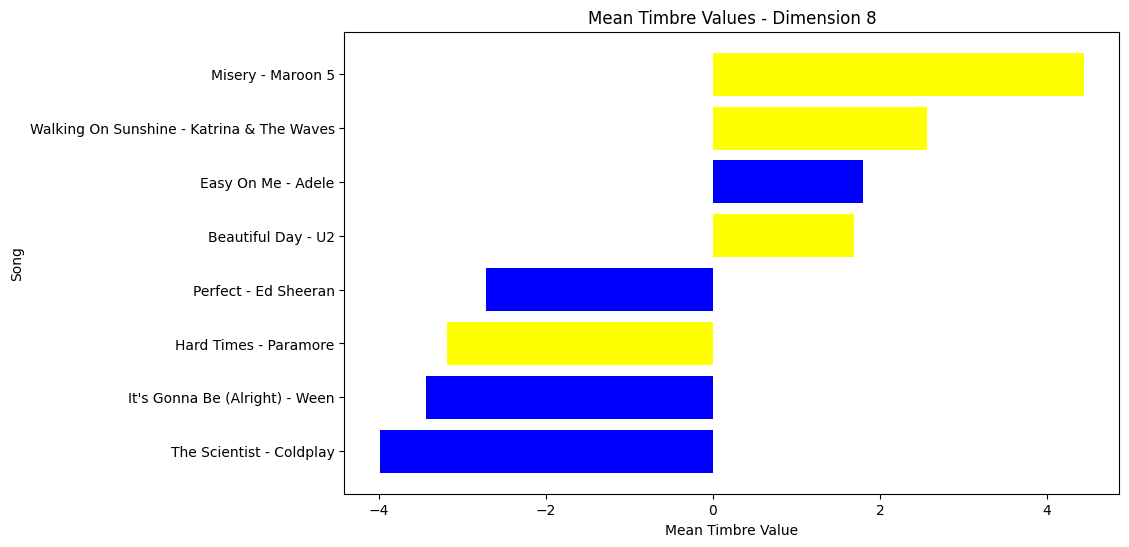

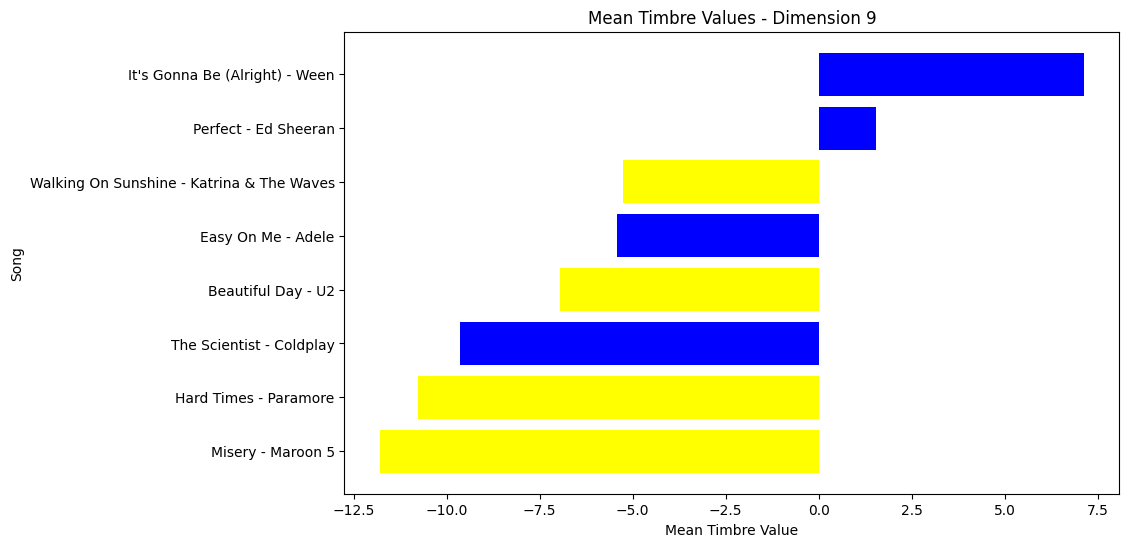

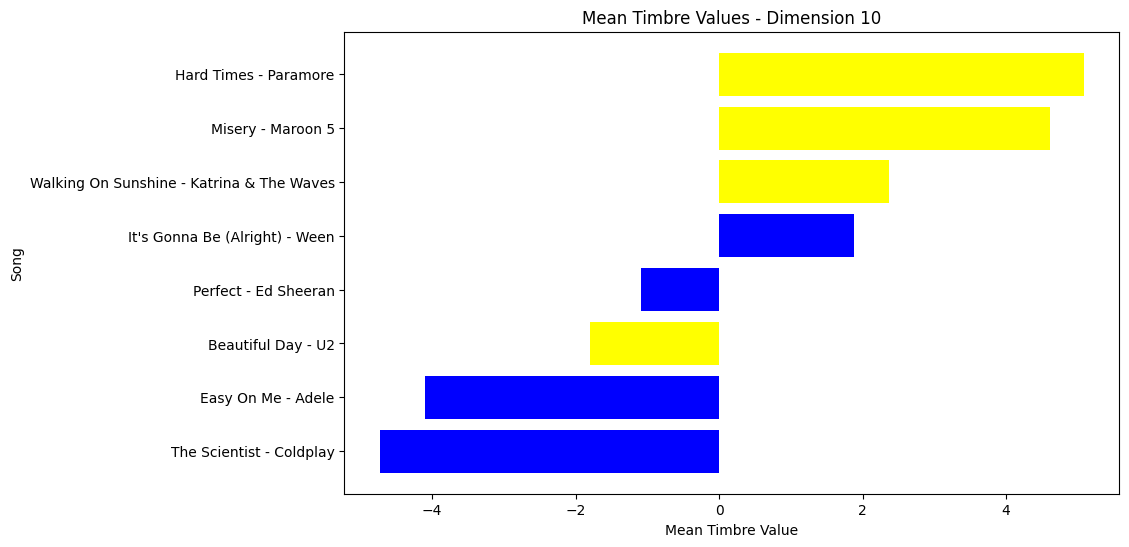

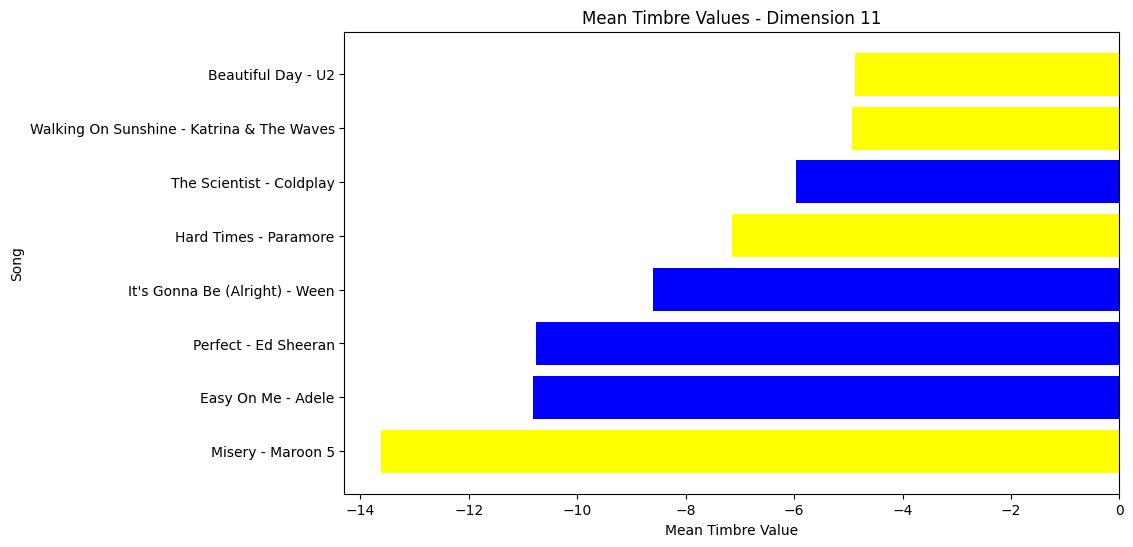

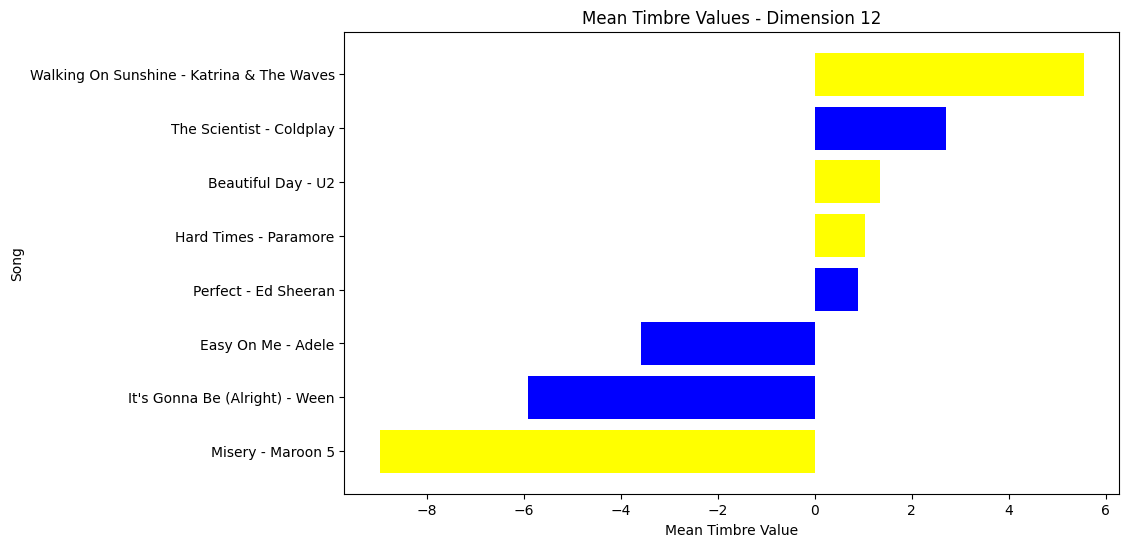

In [13]:
# Get timbre
timbre_summaries = [song_data['timbre'] for song_data in audio_features_list]
track_names = [f"{song_data['name']} - {song_data['artist']}" for song_data in audio_features_list]

# Extract dimension names (assuming there are 12 dimensions)
dimension_names = [f'Dimension {i+1}' for i in range(12)]

# Create a horizontal bar chart
for i, dim_name in enumerate(dimension_names):
    plt.figure(figsize=(10, 6))
    
    # Use sorted indices to order the bars
    sorted_indices = sorted(range(len(timbre_summaries)), key=lambda k: [summary[i] for summary in timbre_summaries][k])
    
    # Assign colors based on labels
    colors = np.where(np.array([audio_features_list[j]['label'] for j in sorted_indices]) == 'S', 'blue', 'yellow')
    
    plt.barh(range(len(timbre_summaries)), [timbre_summaries[j][i] for j in sorted_indices], align='center', color=colors)
    
    plt.xlabel('Mean Timbre Value')
    plt.ylabel('Song')
    plt.title(f'Mean Timbre Values - {dim_name}')
    
    # Use sorted track names
    plt.yticks(range(len(timbre_summaries)), [track_names[j] for j in sorted_indices])
    
    plt.show()
